In [1]:
import os
import json
from PIL import Image

import numpy as np
import pandas as pd

import math

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch import Tensor
from torchvision.models import resnet50
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from natsort import natsorted

MAX_FRAMES = 3
# define the network
IMGM_PATH = 'tutorials/offline_models/resnet/resnet'
TRAIN_PATH = 'datasets/train_big'
VAL_PATH = 'datasets/val_big'

In [2]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Request GPU device 0
    device = torch.device("cuda:0")
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

Using GPU: NVIDIA RTX A5000


In [3]:
class TaskDataset(Dataset):
    # todo: this is not the most efficient way to access data, since each time it has to read from the directory 
    def __init__(self, root_dir,):
        self.root_dir = root_dir
        # preprocessing steps for pretrained ResNet models
        self.transform = transforms.Compose([
                            transforms.Resize(224),
                            # transforms.CenterCrop(224), # todo: to delete for shapenet task; why?
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])

        # check the size of the dataset
        self.dataset_size = 0
        items = os.listdir(self.root_dir)
        for item in items:
            item_path = os.path.join(self.root_dir, item)
            # Check if the item is a directory
            if os.path.isdir(item_path):
                self.dataset_size += 1

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        trial_path = os.path.join(self.root_dir, "trial%d"%idx)
        images = []
        
        for fp in natsorted(os.listdir(trial_path)):
            fp = os.path.join(trial_path, fp)

            if fp[-4:] == '.png':
                img = Image.open(fp)
                img = self.transform(img)
                images.append(img)
            elif 'trial_info' in fp:
                info = json.load(open(fp))
                
                actions = self._action_map(info["answers"])

                # npads = MAX_FRAMES - len(actions)
                # actions.extend([-1 for _ in range(0,npads)])
                
                instructions = info['instruction']
        
        images = torch.stack(images)

        return images, torch.tensor(actions)
    
    def _action_map(self, actions):
        updated_actions = []
        for action in actions:
            if action == "null":
                updated_actions.append(2)
            elif action == "false":
                updated_actions.append(0)
            elif action == "true":
                updated_actions.append(1)
        return updated_actions


In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class CNNRNNNet(nn.Module):

    def __init__(self, hidden_size, dim_transformer_ffl=2048, nhead = 16, blocks=2, output_size = 3,):
        super().__init__()

        # set up the CNN model
        self.cnnmodel = torch.load(IMGM_PATH, map_location=device)
        # freeze layers of cnn model
        for paras in self.cnnmodel.parameters():
            paras.requires_grad = False
        # get relu activation of last block of resnet50
        
        self.cnnmodel.layer4[2].relu.register_forward_hook(get_activation('relu'))

        self.cnnlayer = torch.nn.Conv2d(2048, hidden_size, 1) # we can also bring the resnet embedding dim to a number different from hidden size

        self.input_size = hidden_size*7*7
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.in2hidden = nn.Linear(self.input_size, hidden_size)
        self.layer_norm_in = nn.LayerNorm(self.hidden_size)
        
        self.rnn = nn.RNN(
            input_size = self.hidden_size, 
            hidden_size = self.hidden_size,
            nonlinearity = "relu", # guarnatee positive activations
            )

        self.pos_emb = PositionalEncoding(hidden_size, MAX_FRAMES)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, dim_feedforward=dim_transformer_ffl, nhead=nhead, batch_first=False)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=blocks)
        
        self.layer_norm_rnn = nn.LayerNorm(self.hidden_size)
        self.hidden2output = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input_img, hidden_state = None, is_noise = False,):
        # preprocess image with resnet
        self.batch_size = input_img.shape[0]
        self.seq_len = input_img.shape[1]
        
        x = torch.swapaxes(input_img, 0, 1).float()# (seq_len, batchsize, nc, w, h)
        
        x_acts = []
        cnn_acts = []
        for i in range(self.seq_len):
            temp = self.cnnmodel(x[i,:,:,:,:])
            cnn_acts.append(activation["relu"])
            x_act = self.cnnlayer(activation["relu"])
            x_acts.append(x_act) # (batchsize, nc, w, h) = (batchsize, 2048, 7,7)

        x_acts = torch.stack(x_acts, axis = 0) # (seqlen, batchsize,nc, w,h) rnn_activations
        # self.cnn_acts = torch.stack(cnn_acts, axis = 0) # (seqlen, batchsize, nc, w,h) 
        # self.cnn_acts_down = x_acts
        
        
        x_acts = x_acts.reshape(x_acts.shape[0], self.batch_size, -1) # flatten nc,w,h into one dim
        
        
        """ RNN METHOD """
        if hidden_state == None:
            self.hidden_state = self.init_hidden(batch_size = self.batch_size)
        hidden_x = self.layer_norm_in(torch.relu(self.in2hidden(x_acts.float()))).to(device)
        rnn_output, _ = self.rnn(hidden_x, self.hidden_state.to(device))
        rnn_output = self.layer_norm_rnn(rnn_output)
        out = self.hidden2output(torch.tanh(rnn_output))
        
        """ TRANSFORMER METHOD """
#         hidden_x = self.layer_norm_in(self.pos_emb(self.in2hidden(x_acts.float())))
#         encoder_output = self.encoder(hidden_x)
#         out = self.hidden2output(encoder_output)
        
        return out
        


    def init_hidden(self, batch_size):
        return nn.init.kaiming_uniform_(torch.empty(1, batch_size, self.hidden_size))
            
class PositionalEncoding(nn.Module):
    # Positional encoding module taken from PyTorch Tutorial
    # Link: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, d_model: int, max_len: int = MAX_FRAMES):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return x


In [5]:
# Try warmup (v important)
# Learning rate (cosine learning rate)
# Ask what worked for his transformer
# VINT -> navigation

In [6]:
train_TD = TaskDataset(TRAIN_PATH)
val_TD = TaskDataset(VAL_PATH)
                 
batch_size = 256
data_loaders = [DataLoader(train_TD, batch_size=batch_size, shuffle=True),
                DataLoader(val_TD, batch_size=batch_size, shuffle=False)]
                
model = CNNRNNNet(hidden_size = 256, output_size = 3,).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, T_mult=1 )

print(len(train_TD))
print(len(val_TD))
                                                                 # torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2)

35000
3000


In [7]:
import sklearn

# Calculates the number of correct null action predictions and the number of correct non-null action predictions
def correct(preds, targs):
    null_idxs = torch.where(targs.cpu() == 2)
    non_null_idxs = torch.where(targs.cpu() < 2)
    
    null_preds = preds[null_idxs]
    non_null_preds = preds[non_null_idxs]
    
#     print('null preds', null_preds)
#     print('null trags', targs[null_idxs])
    
#     print('non null preds', non_null_preds)
#     print('non null trags', targs[non_null_idxs])
    
    # print(sklearn.metrics.classification_report(targs[non_null_idxs].cpu().numpy(), non_null_preds.cpu().numpy()))
    
    c_null = torch.sum(null_preds == targs[null_idxs])
    n_null = len(null_preds)
    null_acc = c_null/n_null
    
    c_non_null = torch.sum(non_null_preds == targs[non_null_idxs])
    n_non_null = len(non_null_preds)
    non_null_acc = c_non_null/n_non_null
    
    return null_acc, non_null_acc

# Calculates the loss for a forward pass for both null and non-null action predictions (this is to avoid overfitting to null actions)
def loss(preds, targs):
    # Find indexes of null frames and non-null frames
    null_idxs = torch.where(targs.cpu() == 2)
    non_null_idxs = torch.where(targs.cpu() < 2)
    
    # Add batch dimension and reorder into (batch_size, n_classes, seq_len)
    null_preds = preds[null_idxs]
    non_null_preds = preds[non_null_idxs]

    null_loss = criterion(null_preds, targs[null_idxs])
    non_null_loss = criterion(non_null_preds, targs[non_null_idxs])
    
    return null_loss, non_null_loss, len(null_idxs)/len(non_null_idxs)
    

In [8]:
all_loss = {'train_null_loss':[],'train_non_null_loss':[], 'val_null_loss':[], 'val_non_null_loss':[]}
all_acc = {'train_null_acc':[], 'train_non_null_acc':[], 'val_null_acc':[], 'val_non_null_acc':[]}

def validate():
    
    null_accs = []
    non_null_accs = []
    null_losses = []
    non_null_losses = []

    for images, actions in data_loaders[1]:
        model.eval()
        output = model(images.to(device))
        null_loss, non_null_loss, scale = loss(output.permute(1,0,2).reshape(-1,3), actions.type(torch.LongTensor).reshape(-1).to(device))
        null_losses.append(null_loss.item())
        non_null_losses.append(non_null_loss.item())
        
        # print(actions.reshape(-1)[0:10])
        _, predicted = torch.max(output.data, 2)
        predicted = predicted.permute(1,0).reshape(-1)
        # print(predicted[0:10])
        null_acc, non_null_acc = correct(predicted, actions.reshape(-1).to(device))
        null_accs.append(null_acc.cpu())
        non_null_accs.append(non_null_acc.cpu())
    
    all_loss['val_null_loss'].append(sum(null_losses)/len(null_losses))
    all_loss['val_non_null_loss'].append(sum(non_null_losses)/len(non_null_losses))
    all_acc['val_null_acc'].append(sum(null_accs)/len(null_accs))
    all_acc['val_non_null_acc'].append(sum(non_null_accs)/len(non_null_accs))
    
    print("average val null acc %.2f" % (sum(null_accs)/len(null_accs)))
    print("average val non-null acc %.2f" % (sum(non_null_accs)/len(non_null_accs)))

for epoch in range(30):
    i = 0
    
    null_accs = []
    non_null_accs = []
    null_losses = []
    non_null_losses = []
    for images, actions in data_loaders[0]:
        model.train()
        optimizer.zero_grad()
        output = model(images.to(device)) # (seq_len, batch, n_classes)
        null_loss, non_null_loss, scale = loss(output.permute(1,0,2).reshape(-1,3), actions.type(torch.LongTensor).reshape(-1).to(device))
        
        null_losses.append(null_loss.item())
        non_null_losses.append(non_null_loss.item())
        # if i%30 != 0:
        #     null_loss = 0
        null_loss = 0
        train_loss = null_loss + non_null_loss # *scale *(1/(scale**(epoch/2)))
        train_loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 2)
        predicted = predicted.permute(1,0).reshape(-1)
        null_acc, non_null_acc = correct(predicted, actions.reshape(-1).to(device))
        null_accs.append(null_acc.cpu())
        non_null_accs.append(non_null_acc.cpu())
        
        # scheduler.step(epoch + i / len(data_loaders[0]))
        i += 1

    print('epoch: ', epoch)
    print('train null acc: ', null_acc)
    print('train non-null acc: ', non_null_acc)
    validate()
    all_loss['train_null_loss'].append(sum(null_losses)/len(null_losses))
    all_loss['train_non_null_loss'].append(sum(non_null_losses)/len(non_null_losses))
    all_acc['train_null_acc'].append(sum(null_accs)/len(null_accs))
    all_acc['train_non_null_acc'].append(sum(non_null_accs)/len(non_null_accs))
        

epoch:  0
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.5707, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.49
epoch:  1
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.5217, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.50
epoch:  2
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.5924, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.49
epoch:  3
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.5272, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.49
epoch:  4
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.6250, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.48
epoch:  5
train null acc:  tensor(0., device='cuda:0')
train non-null acc:  tensor(0.7174, device='cuda:0')
average val null acc 0.00
average val non-null acc 0.49
epoch:  6
train 

In [9]:
validate()

average val null acc 0.00
average val non-null acc 0.49


In [10]:
import matplotlib.pyplot as plt

def plot_dict(dict_arrays, use_xlabel='Epochs', use_ylabel='Value', use_title=None):
    # Font size select custom or adjusted on `magnify` value.
    font_size = np.interp(0.1, [0.1,1], [10.5,50])

    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
        )

    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if 0 > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * 1 + 0
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * 1
            max_steps = steps if len(max_steps) < len(steps) else max_steps

        # Plot array as a single line.
        plt.plot(steps, array, linestyle=(['-'] * len(dict_arrays))[index], label=use_label)

        # Plots points values.
        if ([False] * len(dict_arrays))[index]:
            # Loop through each point and plot the label.
            for x, y in zip(steps, array):
                # Add text label to plot.
                plt.text(x, y, str(round(y, 3)), fontdict=font_dict)

    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, None, rotation=0)

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])

    # Adjust font for title.
    font_dict['size'] *= 1.8

    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)

    # Rescale `magnify` to be used on inches.
    magnify = 0.1
    magnify *= 15

    # Display grid depending on `use_grid`.
    plt.grid(True)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * 3 * magnify, figsize[1] * 1 * magnify]

    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)

    return

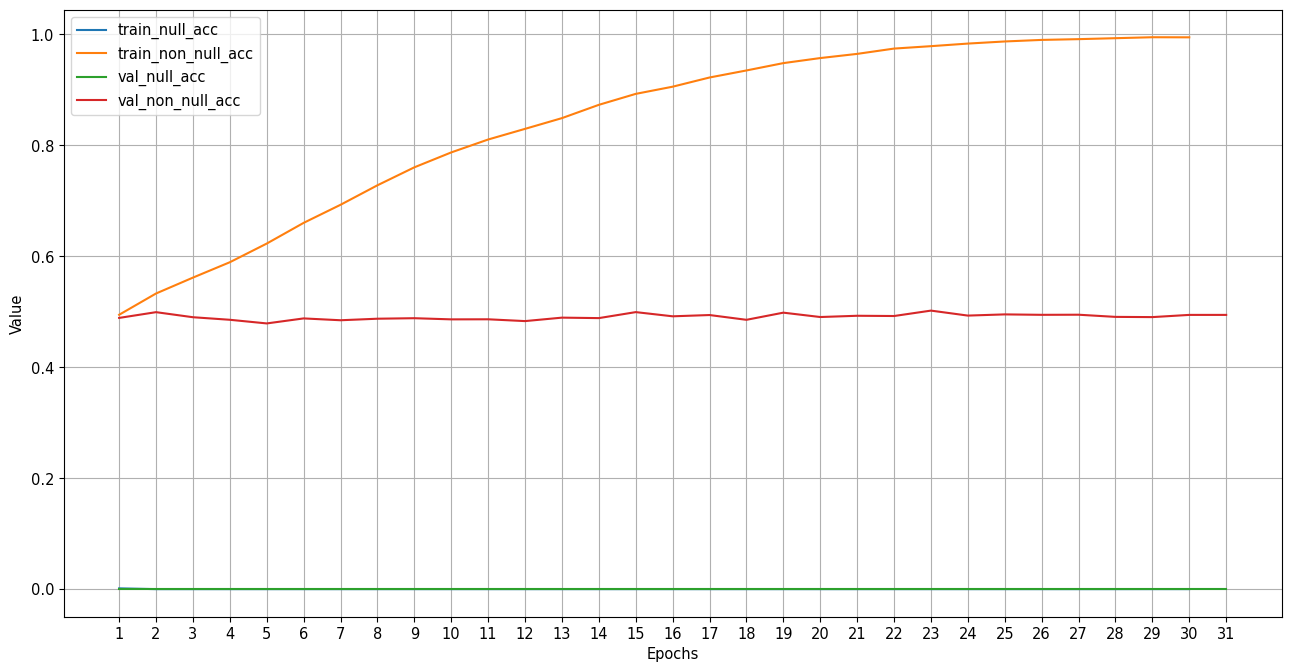

In [11]:
plot_dict(all_acc)

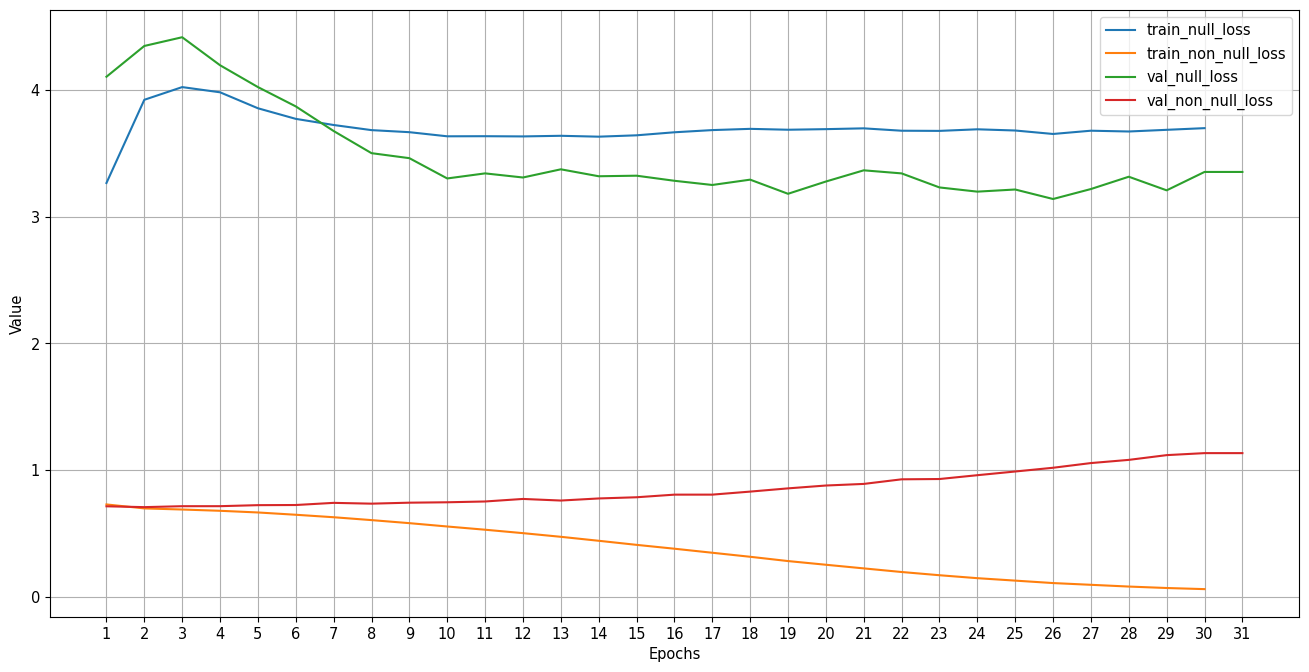

In [12]:
plot_dict(all_loss)